# (1) Import of needed libraries

In [1]:
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

import gensim
from gensim import corpora

from gensim.models import TfidfModel
import numpy as np

from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

from gensim.models.ldamodel import LdaModel
from pprint import pprint

from gensim.models import HdpModel

# (2) Import of complaint data

In [2]:
df = pd.read_csv('complaints.csv',dtype = {'ZIP code': str})

pd.set_option('display.max_colwidth', None)

df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2022-11-19,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"EQUIFAX, INC.",TX,78541,Servicemember,NaN,Web,2022-11-19,In progress,Yes,NaN,6222374
1,2022-10-13,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Improper use of your report,Reporting company used your report improperly,"In accordance with the fair credit reporting act XXXX account XXXX XXXX # XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX Has violated my rights,15 U.S.C.1681 section 602 A states that I have a right to my privacy. 1 5 U.S.C. 1681 section 602 A section 2 states a consumer reporting company can not furnish an account without my written instructions which I have never given.",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",GA,30043,NaN,Consent provided,Web,2022-10-13,Closed with explanation,Yes,NaN,6079679
2,2022-10-13,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Information belongs to someone else,"This is not a duplicate nor is this complaint filed by a third party. I am filing this complaint myself. Please see this complaint is processed to the letter of the law. Again, I was going through my records & noticed the fraudulent accounts which do not belong to me STILL reposting on my file in Transunion. The other bureaus have already DELETED this fraudulent information so my question is why do you still report these damaging records? I also contacted XXXX XXXX XXXX and then talked to their staff, and they agreed to remove the accounts from my file. I have already disputed these accounts several times and stated that I am an identity theft victim. I even forwarded my FTC report I filed online on their website along with my personal information and documents but still, you chose to continue reporting these accounts. Credit Bureaus are bound to comply with the FCRA regulation section 605b but you never cared nor paid any attention to my Disputes. You became negligent of the FCRA law and continued reporting this information on my Credit File without Proper Verification or Investigation. Now, I want you to REMOVE these items from my file like the other bureaus have done. \n\nXXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,90660,NaN,Consent provided,Web,2022-10-13,Closed with non-monetary relief,Yes,NaN,6076990
3,2022-10-12,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Personal information incorrect,NaN,Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19148,NaN,Consent not provided,Web,2022-10-12,Closed with non-monetary relief,Yes,NaN,6080312
4,2022-11-19,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Na

# (3) Data Pre-Processing

## (3.1.a) Data Filtering (1/2)

Number of documents: 1164


<Axes: xlabel='Product'>

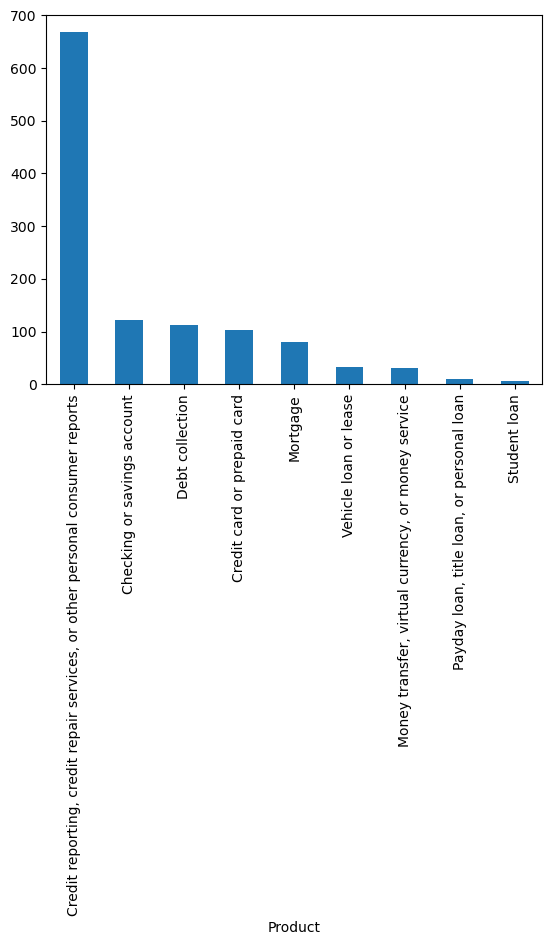

In [3]:
df = df[['Date received', 'Product','Consumer complaint narrative']]
df['Date received']= pd.to_datetime(df['Date received'])

df = df[df['Consumer complaint narrative'].notna()]

df = df[(df['Date received'].dt.year == 2022) & (df['Date received'].dt.month == 11)]

print("Number of documents:", len(df))

df['Product'].value_counts().plot(kind='bar')

## (3.1.b) Data Filtering (2/2)

In [4]:
df = df[(df['Product'] == 'Credit reporting, credit repair services, or other personal consumer reports') ]
print("Number of documents:", len(df))

Number of documents: 668


## (3.2) Tokenization including removal of stopwords, capitalization & filtering on alphabetic data

In [5]:
stopwords = stopwords.words('english') + ["xx", "xxxx","im","please","xxxxxxxx"]

def tokenize (column):
    token_data = nltk.word_tokenize(column)
    return [w.lower() for w in token_data if w.lower() not in stopwords and w.isalpha() and len(w)>2]


df['token_data'] = df['Consumer complaint narrative'].apply(lambda x: tokenize(x))

df.head()

,Date received,Product,Consumer complaint narrative,token_data
86,2022-11-07,"Credit reporting, credit repair services, or other personal consumer reports",There were several inaccurate personal information in my credit report. I am having difficulties in getting them removed. It might be caused by fraud or error on credit reporting.,"[several, inaccurate, personal, information, credit, report, difficulties, getting, removed, might, caused, fraud, error, credit, reporting]"
261,2022-11-01,"Credit reporting, credit repair services, or other personal consumer reports","This is not a duplicate nor is this complaint filed by a third party. I am filing this complaint myself. Please see this complaint is processed to the letter of the law. Regardless of the multiple written requests, the unverified account listed below is still reporting on my credit report in violation of federal law. Under Section 609 ( a ) ( 1 ) ( A ) Disclosures to consumers [ 15 U.S.C. 1681g ] ( ( a ) Information on file ; sources ; report recipients. Experian shall, upon request, and subject to 610 ( a ) ( 1 ) [ 1681h ], clearly and accurately disclose to the consumer. If the consumer to whom the file relates requests that the first 5 digits of the social security number ( or similar identification number ) of the consumer not be included in the disclosure and the consumer reporting agency has received appropriate proof of the identity of the requester, the consumer reporting agency shall so truncate such number in such disclosure. & Section 611 ( a ) ( 1 ) ( A ) Procedure in case of disputed accuracy [ 15 U.S.C. 1681i ] ( a ) Reinvestigations of Disputed Information. If the completeness or accuracy of any item of information contained in my file at Experian is disputed by the consumer and the consumer notifies the agency directly, or indirectly through a creditor, the Bureaus shall, free of charge, conduct a reasonable reinvestigation to determine whether the disputed information is inaccurate and record the current status of the disputed information or delete the items from my file in accordance with paragraph ( 5 ), before the end of the 30-day period beginning on the date on which the agency receives the notice of the dispute from the consumer or creditor. The account below should be corrected ASAP : XXXX XXXX XXXX XXXXXXXX","[duplicate, complaint, filed, third, party, filing, complaint, see, complaint, processed, letter, law, regardless, multiple, written, requests, unverified, account, listed, still, reporting, credit, report, violation, federal, law, section, disclosures, consumers, information, file, sources, report, recipients, experian, shall, upon, request, subject, clearly, accurately, disclose, consumer, consumer, file, relates, requests, first, digits, social, security, number, similar, identification, number, consumer, included, disclosure, consumer, reporting, agency, received, appropriate, proof, identity, requester, consumer, reporting, agency, shall, truncate, number, disclosure, section, procedure, case, disputed, accuracy, reinvestigations, disputed, information, completeness, accuracy, item, information, contained, file, experian, disputed, consumer, consumer, notifies, agency, directly, indirectly, creditor, bureaus, shall, free, charge, ...]"
265,2022-11-05,"Credit reporting, credit repair services, or other personal consumer reports","My name is XXXX XXXX this complaint is not made in error neither is it being made by a third party.I declare under penalty of perjury I am alleging that a person or company- without my authorization- from unauthorized use of my social security number and card used my personal identifying information to apply for goods, services, or money ; and, was successful in creating some accounts. I have no knowledge of this and All is being investigated by the FTC.","[name, complaint, made, error, neither, made, third, declare, penalty, perjury, alleging, person, without, unauthorized, use, social, security, number,

## (3.3.a) Lemmatization (without POS)

In [6]:
lm = WordNetLemmatizer()

#df['lemmatized_tokens'] = df['token_data'].apply(lambda token_list: [lm.lemmatize(token) for token in token_list])

#df.head()

## (3.3.b) Lemmatization (with POS)

In [7]:
df['Pos_Tag'] = df['token_data'].apply(lambda token_list: nltk.pos_tag(token_list))

def lemmatize_with_pos(token_list):
    lemmatized_tokens = []
    for token, tag in token_list:
        if tag.startswith('N'):  # Noun
            lemmatized_tokens.append(lm.lemmatize(token, 'n'))
        elif tag.startswith('V'):  # Verb
            lemmatized_tokens.append(lm.lemmatize(token, 'v'))
        elif tag.startswith('R'):  # Adverb
            lemmatized_tokens.append(lm.lemmatize(token, 'r'))
        elif tag.startswith('J'):  # Adjective
            lemmatized_tokens.append(lm.lemmatize(token, 'a'))
        else:
            lemmatized_tokens.append(lm.lemmatize(token))
    return lemmatized_tokens

df['lemmatized_pos_tokens'] = df['Pos_Tag'].apply(lambda token_list: lemmatize_with_pos(token_list))

df.head()

,Date received,Product,Consumer complaint narrative,token_data,Pos_Tag,lemmatized_pos_tokens
86,2022-11-07,"Credit reporting, credit repair services, or other personal consumer reports",There were several inaccurate personal information in my credit report. I am having difficulties in getting them removed. It might be caused by fraud or error on credit reporting.,"[several, inaccurate, personal, information, credit, report, difficulties, getting, removed, might, caused, fraud, error, credit, reporting]","[(several, JJ), (inaccurate, JJ), (personal, JJ), (information, NN), (credit, NN), (report, NN), (difficulties, NNS), (getting, VBG), (removed, VBD), (might, MD), (caused, VBN), (fraud, NN), (error, NN), (credit, NN), (reporting, NN)]","[several, inaccurate, personal, information, credit, report, difficulty, get, remove, might, cause, fraud, error, credit, reporting]"
261,2022-11-01,"Credit reporting, credit repair services, or other personal consumer reports","This is not a duplicate nor is this complaint filed by a third party. I am filing this complaint myself. Please see this complaint is processed to the letter of the law. Regardless of the multiple written requests, the unverified account listed below is still reporting on my credit report in violation of federal law. Under Section 609 ( a ) ( 1 ) ( A ) Disclosures to consumers [ 15 U.S.C. 1681g ] ( ( a ) Information on file ; sources ; report recipients. Experian shall, upon request, and subject to 610 ( a ) ( 1 ) [ 1681h ], clearly and accurately disclose to the consumer. If the consumer to whom the file relates requests that the first 5 digits of the social security number ( or similar identification number ) of the consumer not be included in the disclosure and the consumer reporting agency has received appropriate proof of the identity of the requester, the consumer reporting agency shall so truncate such number in such disclosure. & Section 611 ( a ) ( 1 ) ( A ) Procedure in case of disputed accuracy [ 15 U.S.C. 1681i ] ( a ) Reinvestigations of Disputed Information. If the completeness or accuracy of any item of information contained in my file at Experian is disputed by the consumer and the consumer notifies the agency directly, or indirectly through a creditor, the Bureaus shall, free of charge, conduct a reasonable reinvestigation to determine whether the disputed information is inaccurate and record the current status of the disputed information or delete the items from my file in accordance with paragraph ( 5 ), before the end of the 30-day period beginning on the date on which the agency receives the notice of the dispute from the consumer or creditor. The account below should be corrected ASAP : XXXX XXXX XXXX XXXXXXXX","[duplicate, complaint, filed, third, party, filing, complaint, see, complaint, processed, letter, law, regardless, multiple, written, requests, unverified, account, listed, still, reporting, credit, report, violation, federal, law, section, disclosures, consumers, information, file, sources, report, recipients, experian, shall, upon, request, subject, clearly, accurately, disclose, consumer, consumer, file, relates, requests, first, digits, social, security, number, similar, identification, number, consumer, included, disclosure, consumer, reporting, agency, received, appropriate, proof, identity, requester, consumer, reporting, agency, shall, truncate, number, disclosure, section, procedure, case, disputed, accuracy, reinvestigations, disputed, information, completeness, accuracy, item, information, contained, file, experian, disputed, consumer, consumer, notifies, agency, directly, indirectly, creditor, bureaus, shall, free, charge, ...]","[(duplicate, NN), (complaint, NN), (filed, VBN), (third, JJ), (party, NN), (filing, NN), (complaint, NN), (see, VBP), (complaint, NN), (processed, VBN), (letter, NN), (law, NN), (regardless, RB), (multiple, JJ), (written, VBN), (requests, NNS), (unverified, VBD), (account, NN), (listed, VBN), (still, RB

## (3.4) n-gram Implementation

In [8]:
def bigrams(text):
    bigram = gensim.models.Phrases(text)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in text]

df['lemmatized_pos_tokens']=df['lemmatized_pos_tokens'].apply(lambda x:[x])
df['bigrams']=df['lemmatized_pos_tokens'].apply(bigrams)

df['bigrams']=[item for sublist in df['bigrams'] for item in sublist]

df.head()

,Date received,Product,Consumer complaint narrative,token_data,Pos_Tag,lemmatized_pos_tokens,bigrams
86,2022-11-07,"Credit reporting, credit repair services, or other personal consumer reports",There were several inaccurate personal information in my credit report. I am having difficulties in getting them removed. It might be caused by fraud or error on credit reporting.,"[several, inaccurate, personal, information, credit, report, difficulties, getting, removed, might, caused, fraud, error, credit, reporting]","[(several, JJ), (inaccurate, JJ), (personal, JJ), (information, NN), (credit, NN), (report, NN), (difficulties, NNS), (getting, VBG), (removed, VBD), (might, MD), (caused, VBN), (fraud, NN), (error, NN), (credit, NN), (reporting, NN)]","[[several, inaccurate, personal, information, credit, report, difficulty, get, remove, might, cause, fraud, error, credit, reporting]]","[several, inaccurate, personal, information, credit, report, difficulty, get, remove, might, cause, fraud, error, credit, reporting]"
261,2022-11-01,"Credit reporting, credit repair services, or other personal consumer reports","This is not a duplicate nor is this complaint filed by a third party. I am filing this complaint myself. Please see this complaint is processed to the letter of the law. Regardless of the multiple written requests, the unverified account listed below is still reporting on my credit report in violation of federal law. Under Section 609 ( a ) ( 1 ) ( A ) Disclosures to consumers [ 15 U.S.C. 1681g ] ( ( a ) Information on file ; sources ; report recipients. Experian shall, upon request, and subject to 610 ( a ) ( 1 ) [ 1681h ], clearly and accurately disclose to the consumer. If the consumer to whom the file relates requests that the first 5 digits of the social security number ( or similar identification number ) of the consumer not be included in the disclosure and the consumer reporting agency has received appropriate proof of the identity of the requester, the consumer reporting agency shall so truncate such number in such disclosure. & Section 611 ( a ) ( 1 ) ( A ) Procedure in case of disputed accuracy [ 15 U.S.C. 1681i ] ( a ) Reinvestigations of Disputed Information. If the completeness or accuracy of any item of information contained in my file at Experian is disputed by the consumer and the consumer notifies the agency directly, or indirectly through a creditor, the Bureaus shall, free of charge, conduct a reasonable reinvestigation to determine whether the disputed information is inaccurate and record the current status of the disputed information or delete the items from my file in accordance with paragraph ( 5 ), before the end of the 30-day period beginning on the date on which the agency receives the notice of the dispute from the consumer or creditor. The account below should be corrected ASAP : XXXX XXXX XXXX XXXXXXXX","[duplicate, complaint, filed, third, party, filing, complaint, see, complaint, processed, letter, law, regardless, multiple, written, requests, unverified, account, listed, still, reporting, credit, report, violation, federal, law, section, disclosures, consumers, information, file, sources, report, recipients, experian, shall, upon, request, subject, clearly, accurately, disclose, consumer, consumer, file, relates, requests, first, digits, social, security, number, similar, identification, number, consumer, included, disclosure, consumer, reporting, agency, received, appropriate, proof, identity, requester, consumer, reporting, agency, shall, truncate, number, disclosure, section, procedure, case, disputed, accuracy, reinvestigations, disputed, information, completeness, accuracy, item, information, contained, file, experian, disputed, consumer, consumer, notifies, agency, directly, indirectly, creditor, bureaus, shall, free, charge, ...]","[(duplicate, NN), (complaint, NN), (filed, VBN), (third, JJ), (party, NN), (filing, NN), (complaint, NN), (see, VBP), (complaint, NN), (processed, VBN), (lette

## (3.5) Final pre-processed data

Top 50 most common words:
[('report', 1306), ('credit', 1299), ('account', 1017), ('information', 836), ('consumer', 672), ('reporting', 441), ('section', 388), ('item', 374), ('remove', 370), ('dispute', 352), ('file', 347), ('experian', 339), ('inquiry', 333), ('agency', 326), ('state', 303), ('bureau', 301), ('date', 286), ('right', 254), ('also', 236), ('law', 232), ('letter', 219), ('company', 218), ('request', 207), ('identity', 203), ('balance', 192), ('without', 182), ('require', 181), ('theft', 178), ('write', 170), ('payment', 168), ('delete', 167), ('open', 164), ('inaccurate', 161), ('provide', 161), ('record', 160), ('follow', 160), ('complaint', 159), ('send', 159), ('act', 154), ('fcra', 153), ('address', 153), ('creditor', 151), ('make', 150), ('usc', 150), ('name', 144), ('day', 142), ('time', 139), ('authorize', 137), ('receive', 135), ('violation', 133)]


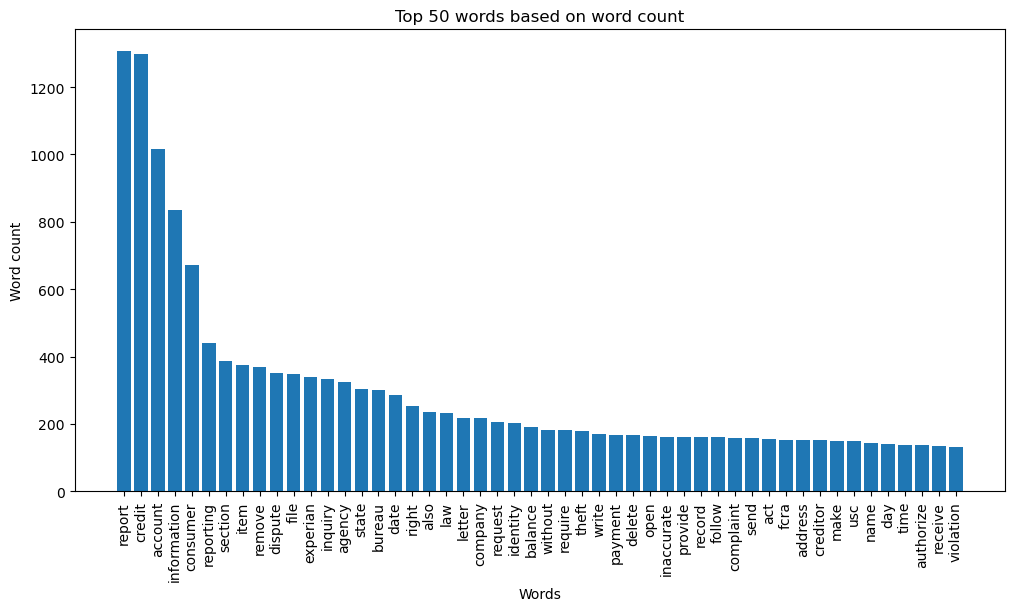

Top 50 words based on word count and their frequency:
{'report': 1.9550898203592815, 'credit': 1.9446107784431137, 'account': 1.5224550898203593, 'information': 1.251497005988024, 'consumer': 1.0059880239520957, 'reporting': 0.6601796407185628, 'section': 0.5808383233532934, 'item': 0.5598802395209581, 'remove': 0.5538922155688623, 'dispute': 0.5269461077844312, 'file': 0.5194610778443114, 'experian': 0.5074850299401198, 'inquiry': 0.49850299401197606, 'agency': 0.4880239520958084, 'state': 0.4535928143712575, 'bureau': 0.4505988023952096, 'date': 0.4281437125748503, 'right': 0.38023952095808383, 'also': 0.3532934131736527, 'law': 0.3473053892215569, 'letter': 0.3278443113772455, 'company': 0.3263473053892216, 'request': 0.30988023952095806, 'identity': 0.30389221556886226, 'balance': 0.2874251497005988, 'without': 0.27245508982035926, 'require': 0.27095808383233533, 'theft': 0.26646706586826346, 'write': 0.25449101796407186, 'payment': 0.25149700598802394, 'delete': 0.25, 'open': 0.24

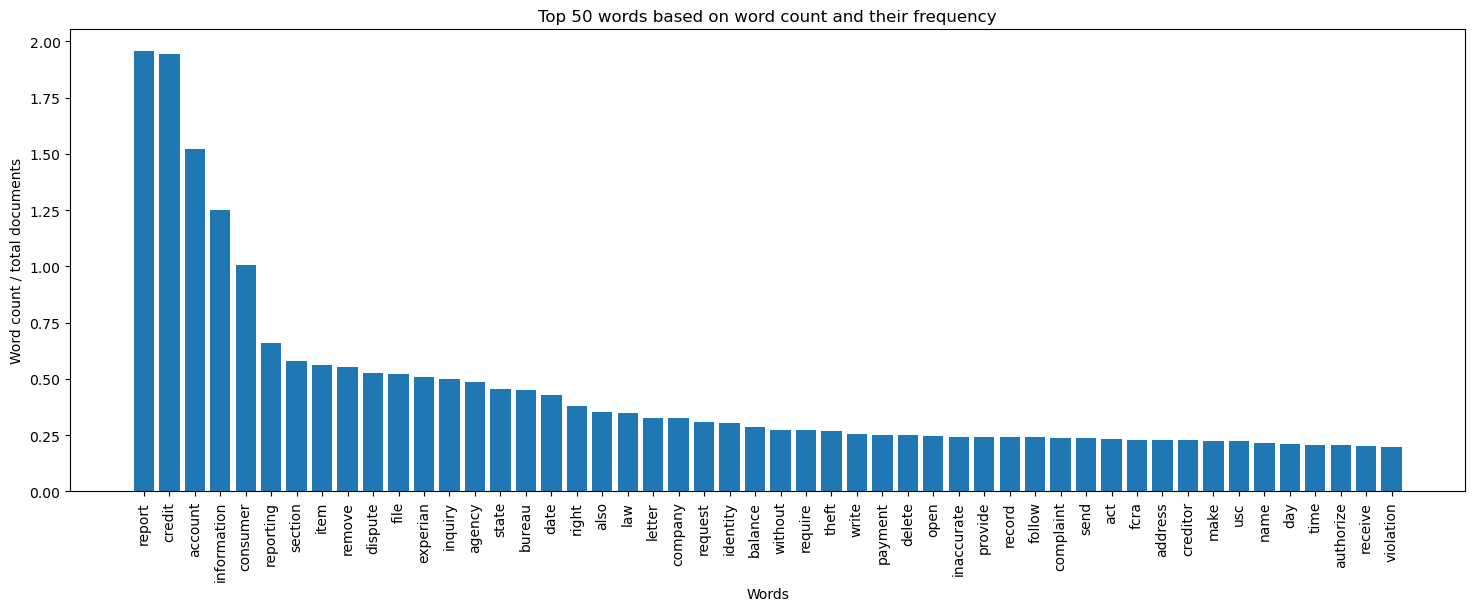

In [9]:

corpus_Top50 = df['bigrams'].tolist()

list_of_lists = [word for sublist in corpus_Top50 for word in sublist]

word_freq = FreqDist(list_of_lists)
top_50_words = dict(word_freq.most_common(50))

print("Top 50 most common words:")
print(word_freq.most_common(50))

plt.figure(figsize=(12,6))
plt.bar(top_50_words.keys(), top_50_words.values())
plt.xticks(rotation='vertical')
plt.title('Top 50 words based on word count')
plt.xlabel('Words')
plt.ylabel('Word count')
plt.show()

no_documents = len(df)

word_freq_share = {word: freq / no_documents for word, freq in top_50_words.items()}
print("Top 50 words based on word count and their frequency:")
print(word_freq_share)

plt.figure(figsize=(18,6))
plt.bar(list(word_freq_share.keys())[:50], list(word_freq_share.values())[:50])
plt.xticks(rotation='vertical')
plt.title('Top 50 words based on word count and their frequency')
plt.xlabel('Words')
plt.ylabel('Word count / total documents')
plt.show()

In [10]:
frequency_threshold = 0.5

tokenized_data = df['bigrams']

list_tokenized_data = df['bigrams'].tolist()
list_of_lists_full = [word for sublist in list_tokenized_data for word in sublist]

word_freq_full = FreqDist(list_of_lists_full)

words_full = dict(word_freq_full)

no_documents_full = len(df)

word_freq_share_full = {word: freq / no_documents_full for word, freq in words_full.items()}

filtered_data = [[word for word in doc if word_freq_share_full[word] <= frequency_threshold] for doc in tokenized_data]

# (4) Vectorization

## (4.1) BoW

In [11]:
corpus = filtered_data
dictionary = corpora.Dictionary(corpus)

dictionary.filter_extremes(no_below=10, no_above=0.95)

bow = [dictionary.doc2bow(text) for text in corpus] 

id_words_bow = [[(dictionary[id], count) for id, count in line] for line in bow]

print(id_words_bow[:5])


[[('cause', 1), ('error', 1), ('fraud', 1), ('get', 1), ('inaccurate', 1), ('personal', 1), ('several', 1)], [('inaccurate', 1), ('accordance', 1), ('accuracy', 2), ('accurately', 1), ('agency', 4), ('appropriate', 1), ('begin', 1), ('bureau', 1), ('case', 1), ('charge', 1), ('clearly', 1), ('complaint', 3), ('completeness', 1), ('conduct', 1), ('contain', 1), ('correct', 1), ('creditor', 2), ('current', 1), ('date', 1), ('delete', 1), ('determine', 1), ('digits', 1), ('directly', 1), ('disclose', 1), ('disclosure', 2), ('disclosures', 1), ('end', 1), ('federal', 1), ('filing', 1), ('first', 1), ('free', 1), ('identification', 1), ('identity', 1), ('include', 1), ('indirectly', 1), ('law', 2), ('letter', 1), ('list', 1), ('multiple', 1), ('notice', 1), ('notifies', 1), ('number', 3), ('paragraph', 1), ('party', 1), ('period', 1), ('procedure', 1), ('process', 1), ('proof', 1), ('reasonable', 1), ('receive', 2), ('recipient', 1), ('record', 1), ('reinvestigation', 1), ('reinvestigations

## (4.2) TF-IDF 

In [12]:
tfidf_model = TfidfModel(dictionary=dictionary, smartirs='ntc')
tfidf = [tfidf_model[dictionary.doc2bow(text)] for text in corpus]

id_words_tfidf = [[(dictionary[id], np.around(freq,decimals=2)) for id, freq in line] for line in tfidf_model[bow]]

print(id_words_tfidf[:5])


[[('cause', 0.41), ('error', 0.46), ('fraud', 0.41), ('get', 0.36), ('inaccurate', 0.26), ('personal', 0.33), ('several', 0.39)], [('inaccurate', 0.06), ('accordance', 0.06), ('accuracy', 0.17), ('accurately', 0.13), ('agency', 0.18), ('appropriate', 0.1), ('begin', 0.11), ('bureau', 0.04), ('case', 0.11), ('charge', 0.09), ('clearly', 0.11), ('complaint', 0.17), ('completeness', 0.12), ('conduct', 0.1), ('contain', 0.09), ('correct', 0.07), ('creditor', 0.14), ('current', 0.1), ('date', 0.06), ('delete', 0.06), ('determine', 0.11), ('digits', 0.14), ('directly', 0.1), ('disclose', 0.12), ('disclosure', 0.26), ('disclosures', 0.14), ('end', 0.09), ('federal', 0.08), ('filing', 0.11), ('first', 0.11), ('free', 0.12), ('identification', 0.11), ('identity', 0.06), ('include', 0.08), ('indirectly', 0.12), ('law', 0.11), ('letter', 0.05), ('list', 0.07), ('multiple', 0.1), ('notice', 0.07), ('notifies', 0.12), ('number', 0.22), ('paragraph', 0.12), ('party', 0.08), ('period', 0.11), ('proce

# (5) Topic Modeling

## (5.1) Latent Semantic Analysis (LSA) / Latent Semantic Indexing (LSI) with BoW

Coherence score with 2 clusters: 0.36220392817231384
Coherence score with 3 clusters: 0.4102253632235063
Coherence score with 4 clusters: 0.4350878143980469
Coherence score with 5 clusters: 0.46936919960670204
Coherence score with 6 clusters: 0.4195800628150781
Coherence score with 7 clusters: 0.5695304806322886
Coherence score with 8 clusters: 0.4115758020501679
Coherence score with 9 clusters: 0.5235395631316502
Coherence score with 10 clusters: 0.43388898214460553
Coherence score with 11 clusters: 0.49648402621784504
Coherence score with 12 clusters: 0.4057013380218841
Coherence score with 13 clusters: 0.4749845730816587
Coherence score with 14 clusters: 0.4354557436407996
Coherence score with 15 clusters: 0.4233219487523064
Coherence score with 16 clusters: 0.3981350364818382
Coherence score with 17 clusters: 0.39608276537615067
Coherence score with 18 clusters: 0.41738653303595685
Coherence score with 19 clusters: 0.3860815267606735
Coherence score with 20 clusters: 0.383471048107

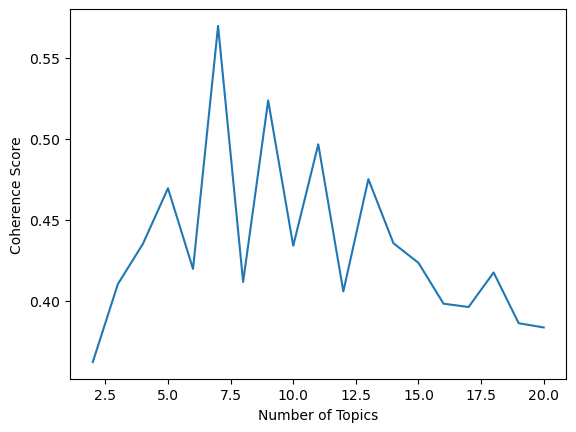

7


In [13]:
df['Assigned_topic_lsi_bow'] = None
df['Topic_score_lsi_bow'] = None


topics = []
score=[]

for i in range(2,21):
    lsi = LsiModel(bow, num_topics = i, id2word = dictionary, power_iters=10)
    coherence_model = CoherenceModel(model=lsi, texts=filtered_data, dictionary=dictionary, coherence ='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))
    
    topics.append(i)
    score.append(coherence_model.get_coherence())
    
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

topic_score_dict = dict(zip(topics, score))
max_dict = max(zip(topic_score_dict.values(),topic_score_dict.keys()))[1]
print(max_dict)

In [14]:
lsi_bow = LsiModel(bow, num_topics=max_dict, id2word=dictionary,power_iters=5)

for topic_num, words in lsi_bow.print_topics(num_words=10):
    print('Words in {}: {}.'.format(topic_num, words))

Words in 0: 0.827*"inquiry" + 0.407*"date" + 0.373*"authorize" + 0.042*"delete" + 0.028*"bureau" + 0.024*"unauthorized" + 0.024*"consent" + 0.020*"letter" + 0.017*"number" + 0.017*"request".
Words in 1: 0.224*"agency" + 0.219*"state" + 0.213*"law" + 0.184*"bureau" + 0.176*"request" + 0.167*"right" + 0.158*"require" + 0.157*"delete" + 0.156*"also" + 0.151*"identity".
Words in 2: -0.309*"require" + -0.277*"identity" + -0.273*"theft" + 0.250*"right" + 0.154*"also" + -0.152*"bureau" + -0.149*"research" + 0.138*"usc" + -0.136*"find" + -0.135*"balance".
Words in 3: 0.320*"state" + 0.315*"agency" + -0.249*"request" + 0.242*"right" + -0.219*"delete" + 0.195*"furnish" + 0.191*"privacy" + 0.177*"person" + 0.161*"usc" + -0.149*"company".
Words in 4: 0.285*"agency" + 0.276*"date" + 0.187*"shall" + 0.186*"number" + 0.183*"request" + -0.167*"company" + -0.159*"payment" + 0.132*"bureau" + -0.127*"make" + -0.126*"inquiry".
Words in 5: 0.264*"term" + 0.247*"also" + 0.221*"state" + 0.221*"different" + 0

In [15]:
topic_space_lsi_bow = lsi_bow[bow]

for i, (row_index, topic_distribution) in enumerate(zip(df.index,topic_space_lsi_bow)):
    dominant_topic = max(topic_distribution, key=lambda x: x[1])
    df.at[row_index,'Assigned_topic_lsi_bow']=dominant_topic[0]
    df.at[row_index,'Topic_score_lsi_bow']=dominant_topic[1]
    
df_lsi_bow = df[['Consumer complaint narrative', 'Assigned_topic_lsi_bow','Topic_score_lsi_bow']] 

df_sorted_lsi_bow = df_lsi_bow.sort_values(by=['Assigned_topic_lsi_bow','Topic_score_lsi_bow'],ascending=[True,False])

df_sorted_lsi_bow = df_sorted_lsi_bow.groupby('Assigned_topic_lsi_bow').head(5)

pd.set_option('display.max_rows', None)
 
display(df_sorted_lsi_bow)


Consumer complaint narrative  \
9153                                                                                                                            Hi, I can't believe you guys are taking advantage of me. I AM VERY UPSET the credit bureaus have not responded back to me about my investigation. I sent a letter, it's more than XXXX. I need these accounts inquiries deleted or updated. These are the items I demanding to be deleted immediately XXXX. The inquiry was not authorized XXXX XXXX  XXXX XXXX inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX  Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX XXXX Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX XXXX XXXX Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXXXXXX XXXX XXXXXXXX XXXX \nDate of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX XXXX XXXX  Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX XXXX of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX XXXX FI Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX XXXX XXXX of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX XXXX XXXX  Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX XXXXXXXX Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXXXXXX XXXX Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX XXXXXXXX Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX XXXX Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX XXXX Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX XXXX XXXX Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXXXXXX XXXX XXXX Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX XXXX XXXXXXXX Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX XXXX XXXX Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX XXXX Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not authorized XXXX XXXX Date of inquiry : XX/XX/XXXX Please remove it from my credit report. \n\nXXXX. The inquiry was not author

## (5.2) Latent Semantic Analysis (LSA) / Latent Semantic Indexing (LSI) with Tf-Idf

Coherence score with 2 clusters: 0.4465797388249573
Coherence score with 3 clusters: 0.453806013716344
Coherence score with 4 clusters: 0.5541836754350078
Coherence score with 5 clusters: 0.44032446606873543
Coherence score with 6 clusters: 0.39804522706955003
Coherence score with 7 clusters: 0.48815900298788906
Coherence score with 8 clusters: 0.5863710666730788
Coherence score with 9 clusters: 0.4254974583636708
Coherence score with 10 clusters: 0.4763454691210587
Coherence score with 11 clusters: 0.4483188756724172
Coherence score with 12 clusters: 0.38782428653790796
Coherence score with 13 clusters: 0.4013536917439127
Coherence score with 14 clusters: 0.43183843033598895
Coherence score with 15 clusters: 0.4060581462251687
Coherence score with 16 clusters: 0.33112116009036896
Coherence score with 17 clusters: 0.3723804304221117
Coherence score with 18 clusters: 0.35872530246096157
Coherence score with 19 clusters: 0.36707537369211213
Coherence score with 20 clusters: 0.35316723620

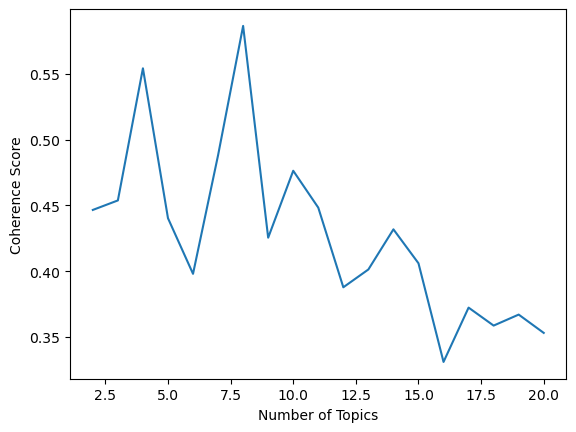

8
Words in 0: 0.284*"right" + 0.273*"state" + 0.196*"agency" + 0.182*"furnish" + 0.182*"privacy" + 0.170*"violate" + 0.157*"instruction" + 0.157*"usc" + 0.154*"write" + 0.152*"act".
Words in 1: -0.306*"right" + -0.259*"state" + -0.218*"privacy" + -0.215*"furnish" + -0.202*"instruction" + -0.194*"violate" + -0.147*"accordance" + 0.146*"inquiry" + 0.142*"balance" + -0.135*"fair".
Words in 2: -0.440*"inquiry" + 0.192*"theft" + 0.184*"identity" + 0.183*"require" + -0.175*"unauthorized" + 0.174*"balance" + -0.156*"company" + -0.144*"hard" + -0.141*"name" + 0.111*"research".
Words in 3: 0.393*"inquiry" + -0.216*"mailed" + -0.216*"involved" + -0.213*"continuously" + -0.212*"upload" + -0.210*"gotten" + -0.209*"thus" + -0.208*"mislead" + -0.205*"far" + -0.202*"happen".
Words in 4: 0.297*"validate" + -0.238*"theft" + -0.213*"identity" + 0.188*"unverified" + 0.178*"erroneous" + 0.178*"fail" + -0.150*"belong" + 0.148*"discover" + -0.140*"victim" + 0.127*"frame".
Words in 5: 0.540*"inquiry" + -0.22

In [16]:

topics_LSI_tfidf = []
score_LSI_tfidf=[]

for i in range(2,21):
    lsi_tfidf = LsiModel(tfidf, num_topics = i, id2word = dictionary, power_iters = 10)
    coherence_model_tfidf = CoherenceModel(model=lsi_tfidf, texts=filtered_data, dictionary=dictionary, coherence ='c_v')
    coherence_score_tfidf = coherence_model_tfidf.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score_tfidf))
    
    topics_LSI_tfidf.append(i)
    score_LSI_tfidf.append(coherence_model_tfidf.get_coherence())
    
_=plt.plot(topics_LSI_tfidf, score_LSI_tfidf)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

topic_score_dict_tfidf = dict(zip(topics_LSI_tfidf, score_LSI_tfidf))
max_dict_tfidf = max(zip(topic_score_dict_tfidf.values(),topic_score_dict_tfidf.keys()))[1]
print(max_dict_tfidf)

lsi_tfidf = LsiModel(tfidf, num_topics=max_dict_tfidf, id2word=dictionary,power_iters=10)

for topic_num, words in lsi_tfidf.print_topics(num_words=10):
    print('Words in {}: {}.'.format(topic_num, words))

In [17]:
lsi_tfidf = LsiModel(tfidf, num_topics=max_dict_tfidf, id2word=dictionary,power_iters=10)

for topic_num, words in lsi_tfidf.print_topics(num_words=10):
    print('Words in {}: {}.'.format(topic_num, words))

Words in 0: 0.284*"right" + 0.273*"state" + 0.196*"agency" + 0.182*"furnish" + 0.182*"privacy" + 0.170*"violate" + 0.157*"instruction" + 0.157*"usc" + 0.154*"write" + 0.152*"act".
Words in 1: -0.306*"right" + -0.259*"state" + -0.218*"privacy" + -0.215*"furnish" + -0.202*"instruction" + -0.194*"violate" + -0.147*"accordance" + 0.146*"inquiry" + 0.142*"balance" + -0.135*"fair".
Words in 2: 0.440*"inquiry" + -0.192*"theft" + -0.184*"identity" + -0.183*"require" + 0.175*"unauthorized" + -0.174*"balance" + 0.156*"company" + 0.144*"hard" + 0.141*"name" + -0.111*"research".
Words in 3: -0.393*"inquiry" + 0.216*"mailed" + 0.216*"involved" + 0.213*"continuously" + 0.212*"upload" + 0.210*"gotten" + 0.209*"thus" + 0.208*"mislead" + 0.205*"far" + 0.202*"happen".
Words in 4: -0.297*"validate" + 0.238*"theft" + 0.213*"identity" + -0.188*"unverified" + -0.178*"erroneous" + -0.178*"fail" + 0.150*"belong" + -0.148*"discover" + 0.140*"victim" + -0.127*"frame".
Words in 5: -0.540*"inquiry" + 0.220*"addre

## (5.3) Latent Dirichlet Allocation (LDA) with BoW

Coherence score with 2 clusters: 0.2984972563829922
Coherence score with 3 clusters: 0.33701709083369513
Coherence score with 4 clusters: 0.3409339847037346
Coherence score with 5 clusters: 0.3216753280621597
Coherence score with 6 clusters: 0.3987270022474579
Coherence score with 7 clusters: 0.3699215120592919
Coherence score with 8 clusters: 0.3492960672477903
Coherence score with 9 clusters: 0.37698030611798117
Coherence score with 10 clusters: 0.4073582820467646
Coherence score with 11 clusters: 0.38714675017824374
Coherence score with 12 clusters: 0.37005524609249885
Coherence score with 13 clusters: 0.3381384339409582
Coherence score with 14 clusters: 0.3863191337169151
Coherence score with 15 clusters: 0.37599659826097337
Coherence score with 16 clusters: 0.34656424269098024
Coherence score with 17 clusters: 0.3562789608652283
Coherence score with 18 clusters: 0.3630752774103604
Coherence score with 19 clusters: 0.33860835537079037
Coherence score with 20 clusters: 0.34417581558

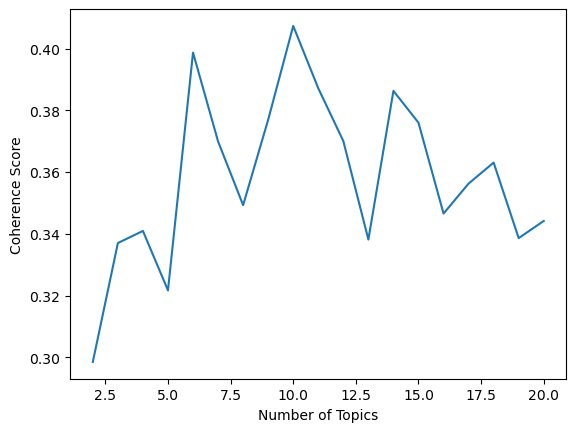

10


In [18]:
topics_LDA_bow = []
score_LDA_bow=[]

for i in range(2,21):
    lda_bow = LdaModel(corpus=bow,id2word=dictionary, num_topics = i, iterations = 100)
    coherence_model_lda_bow = CoherenceModel(model=lda_bow, texts=filtered_data, dictionary=dictionary, coherence ='c_v')
    coherence_score_lda_bow = coherence_model_lda_bow.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score_lda_bow))
    
    topics_LDA_bow.append(i)
    score_LDA_bow.append(coherence_model_lda_bow.get_coherence())
    
_=plt.plot(topics_LDA_bow, score_LDA_bow)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

topic_score_dict_lda_bow = dict(zip(topics_LDA_bow, score_LDA_bow))
max_dict_lda_bow = max(zip(topic_score_dict_lda_bow.values(),topic_score_dict_lda_bow.keys()))[1]
print(max_dict_lda_bow)


In [19]:
lda_bow = LdaModel(corpus=bow,id2word=dictionary, num_topics = max_dict_lda_bow, iterations = 100)

for topic_num, words in lda_bow.print_topics(num_words=10):
    print('Words in {}: {}.'.format(topic_num, words))

Words in 0: 0.032*"right" + 0.031*"state" + 0.021*"agency" + 0.019*"usc" + 0.019*"privacy" + 0.017*"violate" + 0.017*"without" + 0.015*"furnish" + 0.015*"act" + 0.014*"write".
Words in 1: 0.020*"payment" + 0.017*"company" + 0.015*"identity" + 0.015*"theft" + 0.014*"agency" + 0.013*"state" + 0.012*"day" + 0.011*"bureau" + 0.011*"act" + 0.011*"right".
Words in 2: 0.078*"inquiry" + 0.038*"date" + 0.024*"authorize" + 0.023*"state" + 0.023*"agency" + 0.015*"also" + 0.013*"person" + 0.012*"right" + 0.012*"inaccurate" + 0.010*"furnish".
Words in 3: 0.022*"right" + 0.021*"delete" + 0.017*"law" + 0.015*"also" + 0.014*"company" + 0.014*"write" + 0.012*"bureau" + 0.012*"request" + 0.011*"say" + 0.010*"show".
Words in 4: 0.018*"bureau" + 0.018*"require" + 0.015*"letter" + 0.013*"law" + 0.012*"identity" + 0.011*"theft" + 0.011*"find" + 0.011*"research" + 0.011*"provide" + 0.011*"fcra".
Words in 5: 0.041*"address" + 0.022*"name" + 0.016*"open" + 0.015*"number" + 0.014*"balance" + 0.011*"date" + 0.01

## (5.4) Latent Dirichlet Allocation (LDA) with Tf-Idf

Coherence score with 2 clusters: 0.3773620079846626
Coherence score with 3 clusters: 0.32228084054444894
Coherence score with 4 clusters: 0.3676645639203666
Coherence score with 5 clusters: 0.3828354386135257
Coherence score with 6 clusters: 0.338185692902
Coherence score with 7 clusters: 0.3252109271447696
Coherence score with 8 clusters: 0.2979940624706352
Coherence score with 9 clusters: 0.33025393723897406
Coherence score with 10 clusters: 0.2903959588362215
Coherence score with 11 clusters: 0.3016852957379306
Coherence score with 12 clusters: 0.2870367410189158
Coherence score with 13 clusters: 0.3183779016208904
Coherence score with 14 clusters: 0.3368597742648446
Coherence score with 15 clusters: 0.33171043697512964
Coherence score with 16 clusters: 0.3129945950724824
Coherence score with 17 clusters: 0.31600760647147946
Coherence score with 18 clusters: 0.30758859343168177
Coherence score with 19 clusters: 0.28453028836305116
Coherence score with 20 clusters: 0.3041463066570742

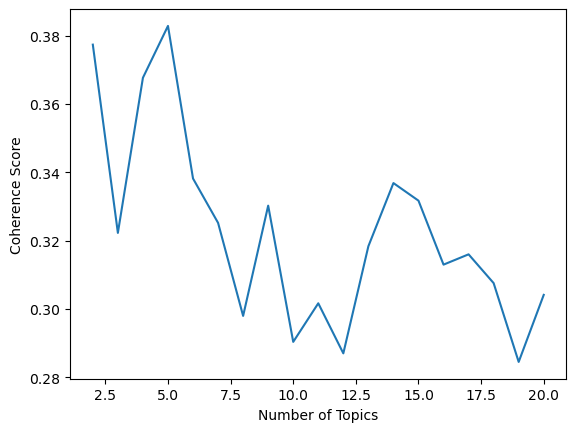

5


In [20]:
topics_LDA_tfidf = []
score_LDA_tfidf=[]

for i in range(2,21):
    lda_tfidf = LdaModel(corpus=tfidf,id2word=dictionary, num_topics = i, iterations = 100)
    coherence_model_lda_tfidf = CoherenceModel(model=lda_tfidf, texts=filtered_data, dictionary=dictionary, coherence ='c_v')
    coherence_score_lda_tfidf = coherence_model_lda_tfidf.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score_lda_tfidf))
    
    topics_LDA_tfidf.append(i)
    score_LDA_tfidf.append(coherence_model_lda_tfidf.get_coherence())
    
_=plt.plot(topics_LDA_tfidf, score_LDA_tfidf)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

topic_score_dict_lda_tfidf = dict(zip(topics_LDA_tfidf, score_LDA_tfidf))
max_dict_lda_tfidf = max(zip(topic_score_dict_lda_tfidf.values(),topic_score_dict_lda_tfidf.keys()))[1]
print(max_dict_lda_tfidf)

In [21]:
lda_tfidf = LdaModel(corpus=tfidf,id2word=dictionary, num_topics = max_dict_lda_tfidf, iterations = 100)

for topic_num, words in lda_tfidf.print_topics(num_words=10):
    print('Words in {}: {}.'.format(topic_num, words))

Words in 0: 0.013*"right" + 0.012*"state" + 0.012*"balance" + 0.010*"bureau" + 0.009*"agency" + 0.008*"date" + 0.008*"write" + 0.008*"never" + 0.008*"law" + 0.008*"creditor".
Words in 1: 0.012*"state" + 0.011*"right" + 0.010*"card" + 0.010*"also" + 0.010*"inaccurate" + 0.009*"payment" + 0.008*"agency" + 0.008*"show" + 0.008*"usc" + 0.008*"ask".
Words in 2: 0.010*"letter" + 0.009*"name" + 0.008*"review" + 0.008*"validate" + 0.007*"complaint" + 0.007*"never" + 0.007*"bureau" + 0.007*"law" + 0.007*"incorrect" + 0.007*"send".
Words in 3: 0.015*"inquiry" + 0.014*"company" + 0.012*"address" + 0.012*"unauthorized" + 0.007*"agency" + 0.007*"name" + 0.006*"code" + 0.006*"business" + 0.006*"provide" + 0.006*"still".
Words in 4: 0.015*"inquiry" + 0.011*"right" + 0.010*"agency" + 0.010*"state" + 0.010*"theft" + 0.009*"identity" + 0.009*"inaccurate" + 0.008*"furnish" + 0.008*"authorize" + 0.008*"date".


## (5.5) Hierarchical Dirichlet Process (HDP) with BoW

In [22]:
hdp_bow = HdpModel(corpus=bow,id2word=dictionary)

for topic_num, words in hdp_bow.print_topics(num_words=10):
    print('Words in {}: {}.'.format(topic_num, words))
    
no_topics = topic_num

Words in 0: 0.012*law + 0.012*bureaus + 0.010*action + 0.010*thus + 0.009*recently + 0.009*set + 0.009*department + 0.009*penalty + 0.009*responsibility + 0.008*accordance.
Words in 1: 0.010*free + 0.010*state + 0.010*ask + 0.009*affect + 0.009*sign + 0.008*source + 0.008*fraud + 0.008*bank + 0.007*authorize + 0.007*request.
Words in 2: 0.012*anything + 0.011*accountable + 0.010*see + 0.009*require + 0.009*visit + 0.009*minimum + 0.009*despite + 0.009*payment + 0.009*local + 0.008*fail.
Words in 3: 0.016*ago + 0.014*transaction + 0.012*signature + 0.011*collection + 0.011*submit + 0.011*responsibility + 0.011*license + 0.010*thus + 0.009*anything + 0.008*deem.
Words in 4: 0.014*upload + 0.011*bureau + 0.009*require + 0.008*constitute + 0.008*alleged + 0.008*situation + 0.007*review + 0.007*block + 0.007*cause + 0.007*creditor.
Words in 5: 0.014*learn + 0.012*think + 0.012*local + 0.011*inform + 0.010*investigation + 0.009*across + 0.009*apply + 0.009*permissible + 0.008*evidence + 0.00

In [23]:
coherence_model_hdp_bow = CoherenceModel(model=hdp_bow, texts=filtered_data, dictionary=dictionary, coherence ='c_v')
coherence_score_hdp_bow = coherence_model_hdp_bow.get_coherence()
print('Coherence score with {} clusters: {}'.format(no_topics, coherence_score_hdp_bow))

Coherence score with 19 clusters: 0.4401919745811933


## (5.6) Hierarchical Dirichlet Process (HDP) with Tf-Idf

In [24]:
hdp_tfidf = HdpModel(corpus=tfidf,id2word=dictionary)

for topic_num, words in hdp_tfidf.print_topics(num_words=10):
    print('Words in {}: {}.'.format(topic_num, words))

Words in 0: 0.012*understand + 0.011*problem + 0.011*fcra + 0.011*verify + 0.010*accurately + 0.010*access + 0.009*assist + 0.009*fix + 0.008*valid + 0.008*specific.
Words in 1: 0.013*deleted + 0.012*access + 0.010*personal + 0.010*removal + 0.009*fix + 0.008*discover + 0.008*party + 0.008*company + 0.007*request + 0.007*despite.
Words in 2: 0.017*local + 0.015*go + 0.012*reinvestigation + 0.010*right + 0.009*united + 0.009*police + 0.009*submit + 0.009*evidence + 0.008*request + 0.008*dont.
Words in 3: 0.016*postal + 0.012*seek + 0.011*investigate + 0.011*prior + 0.011*neither + 0.011*plan + 0.010*security + 0.010*evidence + 0.010*allow + 0.010*attorney.
Words in 4: 0.015*point + 0.012*offer + 0.010*recipient + 0.010*explain + 0.009*hold + 0.009*unknown + 0.009*minimum + 0.009*soon + 0.009*successful + 0.008*validation.
Words in 5: 0.014*minimum + 0.012*incorrect + 0.011*agency + 0.011*specific + 0.010*fail + 0.010*happen + 0.010*knowledge + 0.010*attach + 0.009*past + 0.008*game.
Wor

In [25]:
coherence_model_hdp_tfidf = CoherenceModel(model=hdp_tfidf, texts=filtered_data, dictionary=dictionary, coherence ='c_v')
coherence_score_hdp_tfidf = coherence_model_hdp_tfidf.get_coherence()
print('Coherence score with {} clusters: {}'.format(no_topics, coherence_score_hdp_tfidf))

Coherence score with 19 clusters: 0.4423335078618305
